# Scotland Monthly Birth rate Forecasting

## Step 1: Data Loading

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("monthly_births_table_1.csv")
print("Data Loaded Successfully")
df.head()

Data Loaded Successfully


,Year,Month,NHS Board area,Births registered
0,2025,June,Ayrshire and Arran,273
1,2025,June,Borders,64
2,2025,June,Dumfries and Galloway,82
3,2025,June,Fife,242
4,2025,June,Forth Valley,195


## Step 2 : Trimming the data according to the requirement

In [3]:
df.shape

(6091, 4)

In [4]:
df_new = df[(df["Year"]>=1998) & (df["Year"]<=2022)]

In [5]:
df_new

,Year,Month,NHS Board area,Births registered
450,2022,December,Ayrshire and Arran,191
451,2022,December,Borders,61
452,2022,December,Dumfries and Galloway,68
453,2022,December,Fife,208
454,2022,December,Forth Valley,167
...,...,...,...,...
4931,1998,January,Orkney,11
4932,1998,January,Scotland,4924
4933,1998,January,Shetland,17
4934,1998,January,Tayside,353


##  Step 3: Data Inspection and Preprocessing

In [6]:
df_new.shape

(4486, 4)

In [7]:
df_new.head()

,Year,Month,NHS Board area,Births registered
450,2022,December,Ayrshire and Arran,191
451,2022,December,Borders,61
452,2022,December,Dumfries and Galloway,68
453,2022,December,Fife,208
454,2022,December,Forth Valley,167


In [8]:
df_new.tail()

,Year,Month,NHS Board area,Births registered
4931,1998,January,Orkney,11
4932,1998,January,Scotland,4924
4933,1998,January,Shetland,17
4934,1998,January,Tayside,353
4935,1998,January,Western Isles,26


In [9]:
#descriptive Statistics
print("Dataset Information")
df.info()

Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6091 entries, 0 to 6090
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               6091 non-null   int64 
 1   Month              6091 non-null   object
 2   NHS Board area     6091 non-null   object
 3   Births registered  6091 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 190.5+ KB


### 3.1 Converting Month (from object to int64)



In [10]:
df_new["Month"] = pd.to_datetime(df_new["Month"] , format= "%B").dt.month.astype("int")

C:\Users\PMLS\AppData\Local\Temp\ipykernel_27080\1181845315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Month"] = pd.to_datetime(df_new["Month"] , format= "%B").dt.month.astype("int")


### 3.2 Updating the dataframe by just adding samples other than those where NHS Board area is Scotland

**Note:** In the dataset, some birth counts appear unusually high. This is because rows where the **NHS Board area is "Scotland"** represent the **total births registered across all regions for that month**. To avoid duplication and ensure accurate regional analysis, these aggregate rows have been **excluded from the dataset**.


In [11]:
df_new = df_new[df_new["NHS Board area"]!="Scotland"].reset_index()

### 3.3 : Quality Assessment

In [12]:
print(f"Missing Values in DataFrame : {df_new.isnull().sum().sum()}")
print(f"Zero Birth values if present :{(df_new["Births registered"] == 0).sum()}")
print(f"Negative value of Births register : {(df_new["Births registered"]<0).sum()}")
print(f"Duplicated rows in DataFrame : {df_new.duplicated().sum()}")

Missing Values in DataFrame : 0
Zero Birth values if present :0
Negative value of Births register : 0
Duplicated rows in DataFrame : 0


### 3.4 : Visiualize the distribution of Birth Registered 

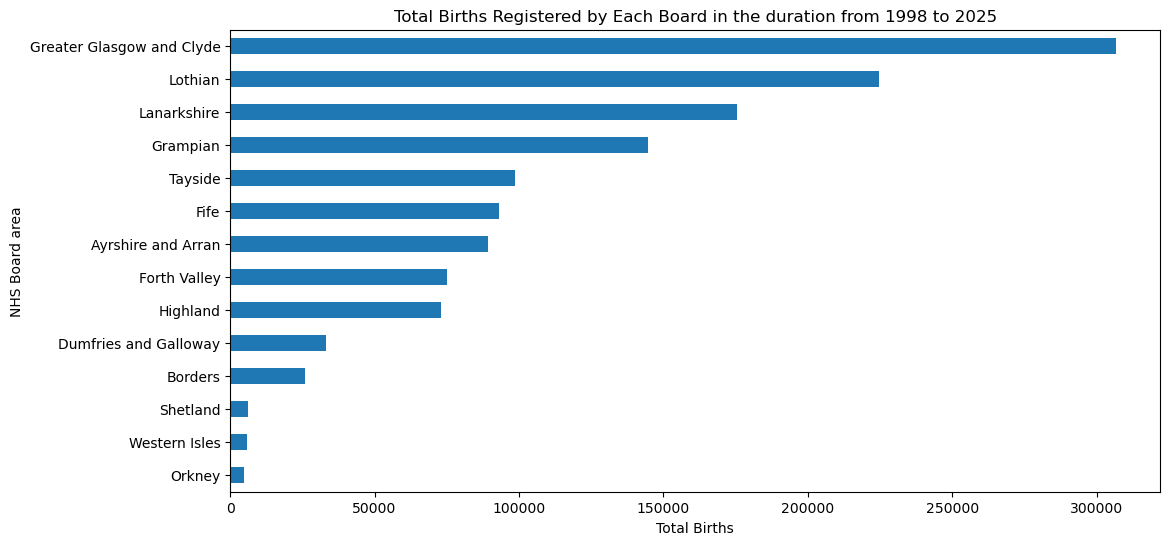

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns# Total Births registered by each board 

plt.figure(figsize =(12, 6))
boards_total = df_new.groupby("NHS Board area")["Births registered"].sum().sort_values()
boards_total.plot(kind = "barh")
plt.title("Total Births Registered by Each Board in the duration from 1998 to 2025")
plt.xlabel("Total Births")
plt.show()


Text(0.5, 1.0, 'Total Births Registered In each Month')

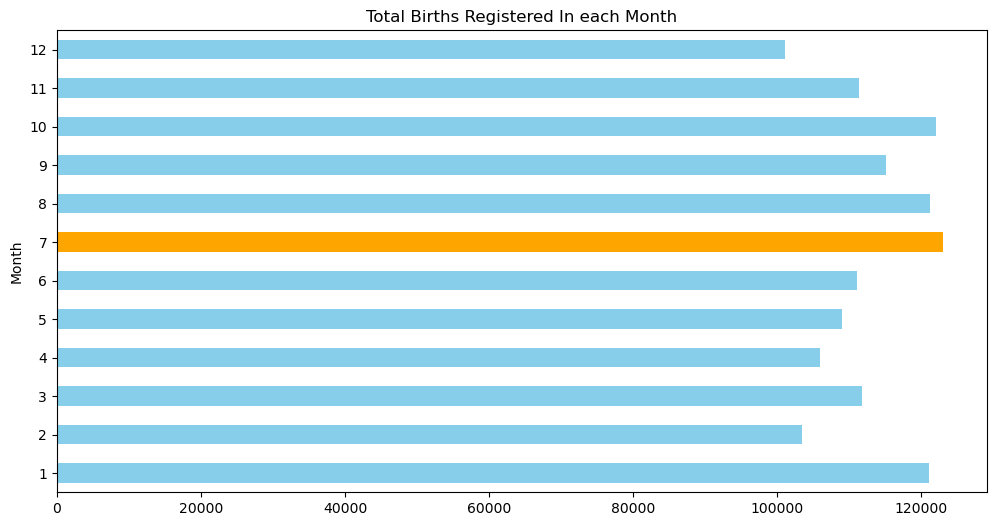

In [14]:
# Monthly distribution of birth registered

plt.figure(figsize=(12,6))
monthly_totals = df_new.groupby("Month")["Births registered"].sum()

# Step 2: Find the index (month) with max value
max_month = monthly_totals.idxmax()

# Step 3: Create a color list
colors = ['skyblue' if month != max_month else 'orange' for month in monthly_totals.index]

monthly_totals.plot(kind = "barh" , color= colors)
plt.title("Total Births Registered In each Month")


### 3.5 Outliers Detection

#### Before:

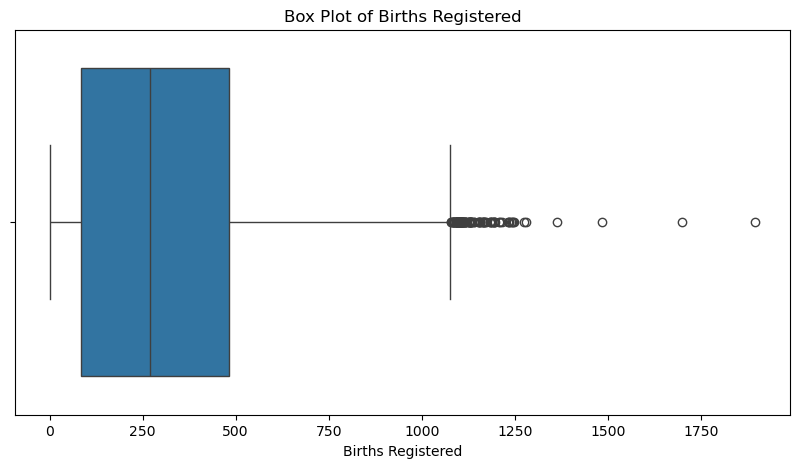

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_new, x="Births registered")
plt.title("Box Plot of Births Registered")
plt.xlabel("Births Registered")
plt.show()


### 3.6 Outlier and skewness handling via Log Transformation
**Since our data is skewed, we apply log transformation to compress large birth counts and expand smaller ones, making the data more balanced and uniform for analysis.**

In [16]:
# Check the skewness value before applying any transformation
skew_value = df_new["Births registered"].skew()
skew_value


# skew_value ~ 0 : symmetric
# skew_value > 0.5 : moderately skewed
# skew_value > 1 : highly skewed

np.float64(1.1039861106422422)

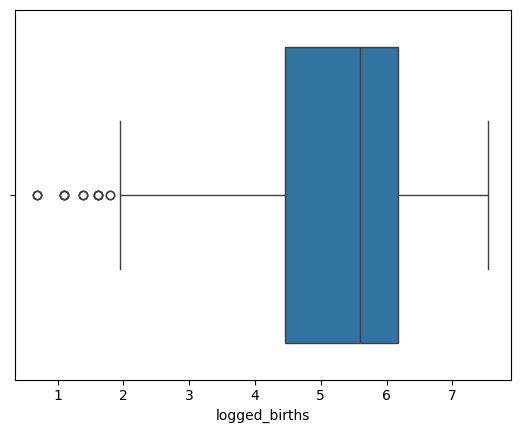

In [17]:
# Applying log transformation as it is best for right skewed data and outliers
df_new["logged_births"] = np.log1p(df_new["Births registered"])
sns.boxplot(data = df_new, x="logged_births")
plt.show()

In [18]:
df_new["logged_births"].skew()


np.float64(-0.718435992444074)

### 3.6 Outlier and skewness handling via IQR

In [19]:
#Handling the outliers
Q1 = df_new["logged_births"].quantile(0.25)
Q3 = df_new["logged_births"].quantile(.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

df_cleaned = df_new[(df_new["logged_births"]>=lower_bound) & (df_new["logged_births"]<=upper_bound)]


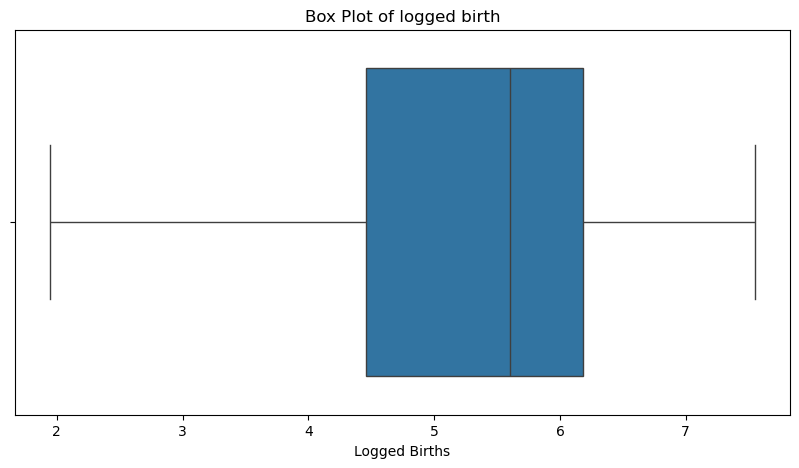

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cleaned, x="logged_births")
plt.title("Box Plot of logged birth")
plt.xlabel("Logged Births")
plt.show()

**Now that our data is free from outliers and any kinda skewness** 

# 4. Aggregating Data to the National Level
- since we are supposed to forecast the monthly birth counts for the whole Scotland.
- And now df_cleaned is at regional level dataframe , we need to convert it into national level.
- Before we split the data , we must need to aggregate the total births in a month in Scotland.

**Why this is necessary:** The objective is to create a single time series representing the total births per month for the entire country, which we will then use for forecasting.

In [21]:
df_cleaned.columns

Index(['index', 'Year', 'Month', 'NHS Board area', 'Births registered',
       'logged_births'],
      dtype='object')

In [22]:
monthly_series = df_cleaned.groupby(["Year" , "Month"])["logged_births"].sum().reset_index()

In [23]:
monthly_series["Date"] = pd.to_datetime(monthly_series["Year"].astype(str) +"-" + monthly_series["Month"].astype(str))


In [24]:
monthly_series = monthly_series.set_index('Date')

In [25]:
monthly_series.sample(10)

,Year,Month,logged_births
Date,,,
2012-04-01,2012,4,73.377218
2015-09-01,2015,9,73.420888
2011-05-01,2011,5,74.411809
2006-10-01,2006,10,74.287517
1999-10-01,1999,10,72.412867
1999-06-01,1999,6,73.391267
2019-08-01,2019,8,71.957612
2018-07-01,2018,7,72.206197
2017-08-01,2017,8,73.040800


In [26]:
# Select only the target column for our time series
scotland_births_ts = monthly_series[['logged_births']]

In [27]:

#  FIX MISSING MONTH (APRIL 2020) VIA INTERPOLATION

#I have come back to here again to do a changing in the data as I observed later on in validation_data that the April Month entrt was missing.
#this happens due to the IQR outlier handling method
#this need to be filled as time series data must be continuous

print("--- Before Handling Missing Value ---")
print("Is April 2020 present?", '2020-04-01' in scotland_births_ts.index)
print("Number of rows:", len(scotland_births_ts))


# 1. Create a complete date range from the start to the end of our data.
#    The 'MS' frequency code stands for 'Month Start'.
full_date_range = pd.date_range(start=scotland_births_ts.index.min(), 
                                end=scotland_births_ts.index.max(), 
                                freq='MS')

# 2. Re-index our time series with this complete date range.
#    This will insert a row for April 2020, and its value will be NaN.
scotland_births_ts_fixed= scotland_births_ts.reindex(full_date_range)


# 3. Use the .interpolate() method to fill the NaN value.
#    The default method is 'linear', which is exactly what we want.
scotland_births_ts_fixed['logged_births'] = scotland_births_ts_fixed['logged_births'].interpolate()


print("\n--- After Handling Missing Value ---")
print("Is April 2020 now present?", '2020-04-01' in scotland_births_ts_fixed.index)
print("Number of rows:", len(scotland_births_ts_fixed))
print("\n--- Data for the 2020 period after interpolation ---")
print(scotland_births_ts_fixed.loc['2020-03-01':'2020-07-01'])


--- Before Handling Missing Value ---
Is April 2020 present? False
Number of rows: 299

--- After Handling Missing Value ---
Is April 2020 now present? True
Number of rows: 300

--- Data for the 2020 period after interpolation ---
            logged_births
2020-03-01      65.695658
2020-04-01      36.817943
2020-05-01       7.940228
2020-06-01      47.390829
2020-07-01      83.186090


# 5 : Splitting the Data

1. Training Set: 1998 – 2018 (for model training)
2. Validation Set: 2019 – 2020 (for hyperparameter tuning and preventing overfitting)
3. Test Set: 2021 – 2022 (for final, unbiased evaluation of the model)

In [28]:
train_end = '2018-12-31'
validation_end = '2020-12-31'

# Perform the split based on the datetime index
train_data = scotland_births_ts_fixed.loc[:train_end]
validation_data = scotland_births_ts_fixed.loc[train_end:validation_end]
test_data = scotland_births_ts_fixed.loc[validation_end:]

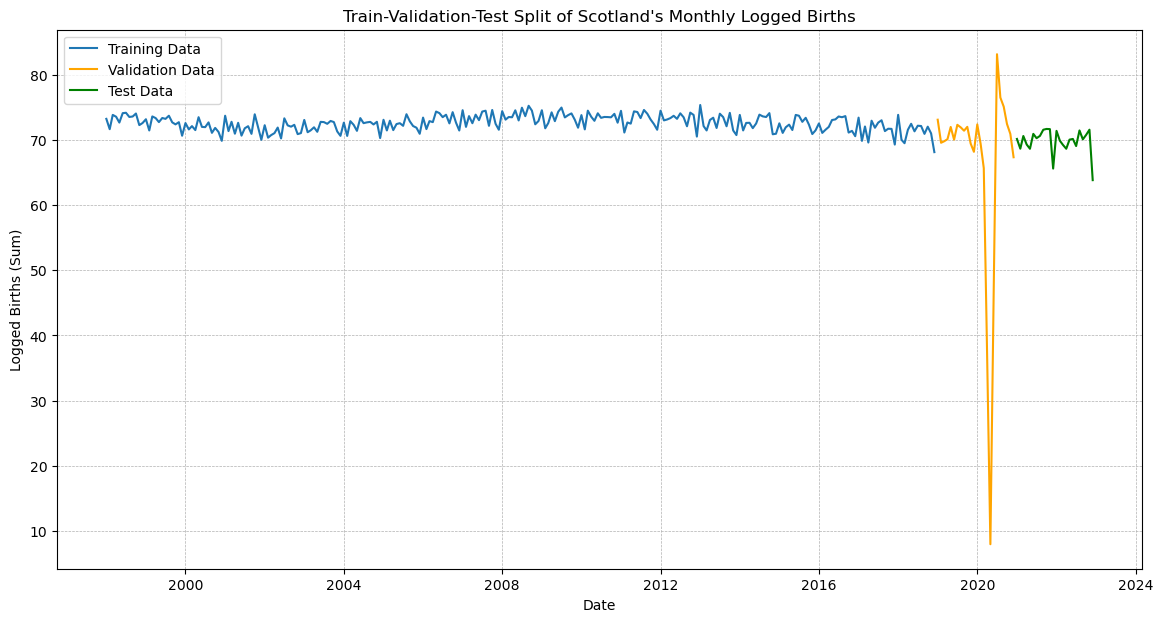

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['logged_births'], label='Training Data')
plt.plot(validation_data.index, validation_data['logged_births'], label='Validation Data', color='orange')
plt.plot(test_data.index, test_data['logged_births'], label='Test Data', color='green')
plt.title("Train-Validation-Test Split of Scotland's Monthly Logged Births")
plt.xlabel("Date")
plt.ylabel("Logged Births (Sum)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### What Is This "Spike"? The Context
That sharp, vertical drop in your validation data (the orange line) corresponds to the initial phase of the COVID-19 pandemic and the subsequent lockdowns in 2020.

Why it happened: During the first major lockdowns (roughly March-May 2020 in the UK), registration offices were closed or had severely limited services. People were legally unable to register births in person. This didn't mean fewer babies were born, but that the registration process was massively disrupted. The data recovered later in the year as offices reopened and backlogs were cleared.

Why it's not a "normal" outlier: Unlike a random data error, this is a structural break or an exogenous shock. It's a real event caused by an external factor that fundamentally, but temporarily, changed the system we are measuring.

## First apprach : Interpolate the value (Tempeoray before modelling or while adding exogenous feature we will not use it or comment it)

In [30]:
# #identify the exact value of anomly in the validation data

# anomaly_date = validation_data["logged_births"].idxmin()
# anomlay_value = validation_data["logged_births"].min()

# # --- Strategy: Interpolation ---
# # We will replace the anomalous value.
# # To do this safely, we'll work on a copy of the validation data.
# validation_data_handled = validation_data.copy()

# # Get the index location of the anomaly
# anomaly_loc = validation_data_handled.index.get_loc(anomaly_date)
# anomaly_loc

# #get the values of the points above and below that anomaly
# prev_val = validation_data_handled.iloc[anomaly_loc-1]["logged_births"]
# after_val = validation_data_handled.iloc[anomaly_loc +1]["logged_births"]


# #interpolated value (average of both )
# interpolated_val = (prev_val + after_val)/2

# validation_data_handled.loc[anomaly_date , "logged_births"] = interpolated_val

In [31]:
# # --- Visualize the result ---
# plt.figure(figsize=(14, 7))
# plt.plot(train_data.index, train_data['logged_births'], label='Training Data')
# plt.plot(validation_data_handled.index, validation_data_handled['logged_births'], label='Validation Data (Handled)', color='orange')
# plt.plot(test_data.index, test_data['logged_births'], label='Test Data', color='green')
# plt.title("Data Split After Handling the 2020 Anomaly")
# plt.xlabel("Date")
# plt.ylabel("Logged Births (Sum)")
# plt.legend()
# plt.show()

In [32]:
# validation_data_handled.head(20)

# 5 : Feature Engineering

### 5.1 : Create Time Embeddings 
Now the need is to cfeate the time embeddings for :
 - Month of the year
 - Year of the series
This will help our model to understand the seasonality of our data like birth rate was higher in june or birth date decrease after 2010 etc.

Why necessary ? 
- Our deep learning models do not understand that 1990-2-1 comes after 1990-1-1 , we have to explicitly tell the model about all these things.

In [33]:
def create_time_features(df):
    
    """
    create time based and exogenous features from a datetime index
    """
    
    df = df.copy()
    #creating time embeddings
     
    df["Month"] = df.index.month
    df["Year"] = df.index.year
    df["Quarter"] =df.index.quarter
    
    #creating exogeneous features
    df["covid_lockdown_indicator"] = 0
    lockdown_starts = "2020-3-1"
    lockdown_ends = "2020-6-1"
    
    df.loc[(df.index >= lockdown_starts) & (df.index <= lockdown_ends), 'covid_lockdown_indicator'] = 1
    
    return df

    
    
    

In [34]:
train_featured = create_time_features(train_data)
validation_featured = create_time_features(validation_data) 
test_featured = create_time_features(test_data)
train_featured

,logged_births,Month,Year,Quarter,covid_lockdown_indicator
1998-01-01,73.260945,1,1998,1,0
1998-02-01,71.674430,2,1998,1,0
1998-03-01,73.869008,3,1998,1,0
1998-04-01,73.587263,4,1998,2,0
1998-05-01,72.689822,5,1998,2,0
...,...,...,...,...,...
2018-08-01,72.160435,8,2018,3,0
2018-09-01,70.955273,9,2018,3,0
2018-10-01,72.060627,10,2018,4,0
2018-11-01,71.027725,11,2018,4,0


In [35]:
validation_featured

,logged_births,Month,Year,Quarter,covid_lockdown_indicator
2019-01-01,73.129732,1,2019,1,0
2019-02-01,69.590613,2,2019,1,0
2019-03-01,69.812721,3,2019,1,0
2019-04-01,70.133445,4,2019,2,0
2019-05-01,72.016682,5,2019,2,0
2019-06-01,70.060966,6,2019,2,0
2019-07-01,72.345593,7,2019,3,0
2019-08-01,71.957612,8,2019,3,0
2019-09-01,71.442244,9,2019,3,0
2019-10-01,72.035764,10,2019,4,0


# 6: Model Building - Statistical Baseline , ARIMA Model

Creating a strong baseline with the traditional model is essential to prove that the complexity of deep learning models is actually providing the benefit.

### 6.1 ARIMA Model :
- It stands for Auto Regressive Integrated MOving Average model . 
- It is on of the most widely used statistical model in the time series forecasting.
- While implementing the ARIMA , we need to find the optimal values for three parameters (p,d,q).
- p is the number of past values the current values we need to consider for finding the current value.
- d is the number time the value is differenced from the past values.
- q is the size of the moving average window.
- we have to find the optimal values of these parameters before we start building the model.
- A function `auto_arima` provided by the `pmdarima` libarary is used to find these values.

In [36]:
import pmdarima as pm

In [37]:

# as auto_arima will find the optimal values based on the data we will provide.
#thus creating the target data

arima_train_data = train_featured["logged_births"]

auto_model = pm.auto_arima(arima_train_data,
                           start_p=1, start_q=1,
                           test='adf',       # Use the ADF test to find the best 'd'
                           max_p=3, max_q=3, # Maximum p and q to test
                           m=12,             # The frequency of the seasonality (12 months)
                           d=None,           # Let the model determine 'd'
                           seasonal=True,    # Enable seasonal search
                           start_P=0,
                           D=1,              # Enforce one seasonal difference
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)


print("\n--- Auto ARIMA Results ---")
print(auto_model.summary())

c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=670.380, Time=0.06 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=667.500, Time=0.15 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=665.178, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=670.949, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=672.312, Time=0.06 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.87 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=667.506, Time=0.11 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=663.429, Time=0.13 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.66 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=658.572, Time=1.17 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.83 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.95 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.78 sec


c:\Users\PMLS\anaconda3\envs\scotland_project\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,2)[12]             : AIC=659.444, Time=0.81 sec

Best model:  ARIMA(0,0,0)(0,1,2)[12] intercept
Total fit time: 15.859 seconds

--- Auto ARIMA Results ---
                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  252
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                -325.286
Date:                       Thu, 31 Jul 2025   AIC                            658.572
Time:                               14:27:56   BIC                            672.495
Sample:                           01-01-1998   HQIC                           664.182
                                - 12-01-2018                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [38]:
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print(f"Best oder (p ,d , q) : {best_order}")
print(f"Best seasonal order (p , d , q , m) : {best_seasonal_order}")

Best oder (p ,d , q) : (0, 0, 0)
Best seasonal order (p , d , q , m) : (0, 1, 2, 12)


### 6.2:  Train the ARIMA Model and Make Predictions
`auto-arima()` method now had fornd the best parameters values for us . Now we need to train our model on full training data and evaluate and test it via validation and testing data respectively.

#### 6.2.1 Training

In [39]:
#Training

from statsmodels.tsa.statespace.sarimax import SARIMAX

print("Training the SARIMAX with the best parameters values")
model = SARIMAX(arima_train_data , order = best_order , seasonal_order = best_seasonal_order)

model_fit = model.fit(disp=False)
print("Done with model training")

Training the SARIMAX with the best parameters values
Done with model training


#### 6.2.2 Predictions

In [40]:
# predictions 

#we need to forecast for the lenght of the valiadtion and the test data combined
n_forecast_steps = len(validation_featured) + len(test_featured)
print(f"forecasting {n_forecast_steps} steps in the future----")

#get the forecast predictions and confidence interval
forecast = model_fit.get_forecast(steps = n_forecast_steps)
forecast_predictions = forecast.predicted_mean

#get the forecast index

forecast_index = pd.date_range(start = validation_featured.index.min() ,
                               periods= n_forecast_steps ,
                               freq = 'MS')

#combine the index nad the forecast predictions into pandas series
forecast_series = pd.Series(forecast_predictions.values , index = forecast_index)
print("Done with forecasting.")


forecasting 48 steps in the future----
Done with forecasting.


#### 6.2.3 Evaluation

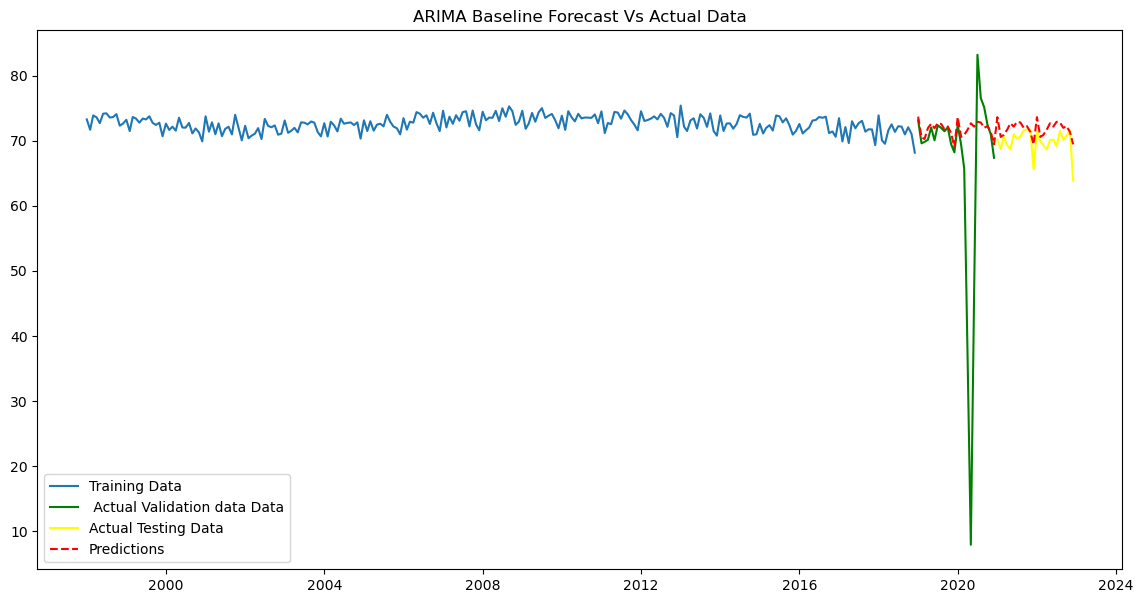

In [41]:
#visiualizing the predictions
plt.figure(figsize=(14,7))
plt.plot(train_featured.index , train_featured["logged_births"] , label = "Training Data")
plt.plot(validation_featured.index , validation_featured["logged_births"] , label = " Actual Validation data Data" , color = "green")
plt.plot(test_featured.index , test_featured["logged_births"] , label = "Actual Testing Data" , color = "yellow")
plt.plot(forecast_series.index , forecast_series.values , label = "Predictions" , color = "red" , linestyle="--")

plt.title("ARIMA Baseline Forecast Vs Actual Data")

plt.legend()
plt.show()

### 6.3 : Calculating Evaluation Metrics for the ARIMA Forecast
Now it's time to quantify our ARIMA model by calculating the following accuracies:
- MAE (difference between actual and predicted values)
- RMAE (squared differences between actual and predicted values , penalizes larger difference more)
- SMAPE ( A perscentage error that is less biased than MAPE , usefull for comparing the forecast accuracy across the time series with different scales)

In [42]:
from sklearn.metrics import mean_absolute_error , root_mean_squared_error

#we will calculate the accuracy metrics for both the validation and test data separatly , 
#we need to find the vlaidation forecast and test forecast

#separate the forecast for validation and test data
arima_val_forecast = forecast_series.loc[validation_featured.index]
arima_test_forecast = forecast_series.loc[test_featured.index]

#get actual values 
val_actual = validation_featured["logged_births"]
test_actual = test_featured["logged_births"]

#creating the function to calculate the SMAPE
def calculate_smape(y_true , y_pred):
    
    numerator = np.abs(y_pred - y_true)
    denomenator = (np.abs(y_pred) + np.abs(y_true))/2
    
    return np.mean(numerator/denomenator) * 100

    
#----------------------------Calculating the acuuracy metrics for Validation data------------------------------#

arima_MAE_val = mean_absolute_error(arima_val_forecast , val_actual)
arima_RMSE_val = root_mean_squared_error(arima_val_forecast , val_actual)
arima_smape_val = calculate_smape(arima_val_forecast , val_actual)

print(f"For validation Data :\nARIMA MAE : {arima_MAE_val:.4f}\nARIMA RMSE : {arima_RMSE_val:.4f}\nARIMA SMAPE : {arima_smape_val:.2f}%")

#----------------------------Calculating the acuuracy metrics for Test data------------------------------#

arima_MAE_test = mean_absolute_error(arima_test_forecast , test_actual)
arima_RMSE_test = root_mean_squared_error(arima_test_forecast , test_actual)
arima_smape_test = calculate_smape(arima_test_forecast , test_actual)

print(f"For testing Data :\nARIMA MAE : {arima_MAE_test:.4f}\nARIMA RMSE : {arima_RMSE_test:.4f}\nARIMA SMAPE : {arima_smape_test:.2f}%")

For validation Data :
ARIMA MAE : 6.7430
ARIMA RMSE : 16.0639
ARIMA SMAPE : 13.24%
For testing Data :
ARIMA MAE : 2.0499
ARIMA RMSE : 2.4585
ARIMA SMAPE : 2.92%


#### 6.4 : Saving Results

In [43]:
arima_results = {
    "MAE" : arima_MAE_test,
    "RMSE" :arima_RMSE_test,
    "SMAPE" : arima_smape_test   
}


**Note on ARIMA Performance:**

The ARIMA model performs well on the stable test set (2.92% SMAPE) but fails significantly on the validation set (13.24% SMAPE). The model was trained on data from 1998-2018 and could not forecast the extreme anomaly in 2020 caused by the COVID-19 pandemic. This illustrates the weakness of ARIMA in handling unforeseen structural breaks in a time series.

# 7: Model Builing - Traditional ML Tree based Model , XGBOOST

Now we 'll build our second baseline , this time a Machine Learning model , XGBOOST .It is tree based gradient boosting algorithm. It needs both features and labels unlike the statistical model , ARIMA.

#### 7.1  Train XGBOOST Model

In [44]:
import xgboost as xgb

In [45]:
print("Building the second baseline with XGBOOST ")

#preapre the data accordingly
Features = ["Month" ,"Year" , "Quarter" , "covid_lockdown_indicator"]
Target = "logged_births"

#Splitting the data into features (inputs) and target(outputs)

#for training
X_train = train_featured[Features]
y_train = train_featured[Target]

#for validation 
X_val = validation_featured[Features]
y_val = validation_featured[Target]

#for testing
X_test = test_featured[Features]
y_test = test_featured[Target]

# Initialize and Train the XGBoost Model
# We use some common default hyperparameters.
# n_estimators is the number of trees in the forest.
# early_stopping_rounds helps prevent overfitting by monitoring the validation loss.

reg = xgb.XGBRegressor(n_estimators = 1000,
                       early_stopping_rounds = 50,
                       learning_rate = 0.01,
                       random_state= 42)

#train the model on the training data and use the valiadtion data to understand when to stop

reg.fit(X_train , y_train ,
        eval_set = [(X_train , y_train) , (X_val , y_val)],
        verbose = 100 ) #print training progress after every 100 rounds

print("\nXGBOOST training is completed")

Building the second baseline with XGBOOST 
[0]	validation_0-rmse:1.23506	validation_1-rmse:16.30536
[100]	validation_0-rmse:0.77210	validation_1-rmse:16.07500
[200]	validation_0-rmse:0.60506	validation_1-rmse:15.99366
[300]	validation_0-rmse:0.53283	validation_1-rmse:15.97938
[400]	validation_0-rmse:0.48873	validation_1-rmse:15.97174
[500]	validation_0-rmse:0.44615	validation_1-rmse:15.96931
[547]	validation_0-rmse:0.43207	validation_1-rmse:15.97093

XGBOOST training is completed


#### 7.2 Making Prediction By XGBOOST

In [46]:
xgboost_test_pred = reg.predict(X_test)

#### 7.3 evaluating the XGBOOST by Evaluating metrics

In [47]:

xgboost_MAE_test = mean_absolute_error(y_test , xgboost_test_pred)
xgboost_RMSE_test = root_mean_squared_error(y_test , xgboost_test_pred)
xgboost_SMAPE_test = calculate_smape(y_test , xgboost_test_pred)

print(f"For testing Data :\nXGBOOST MAE : {xgboost_MAE_test:.4f}\nXGBOOST RMSE : {xgboost_RMSE_test:.4f}\nXGBOOST SMAPE : {xgboost_SMAPE_test:.2f}%")

For testing Data :
XGBOOST MAE : 1.6680
XGBOOST RMSE : 2.0703
XGBOOST SMAPE : 2.38%


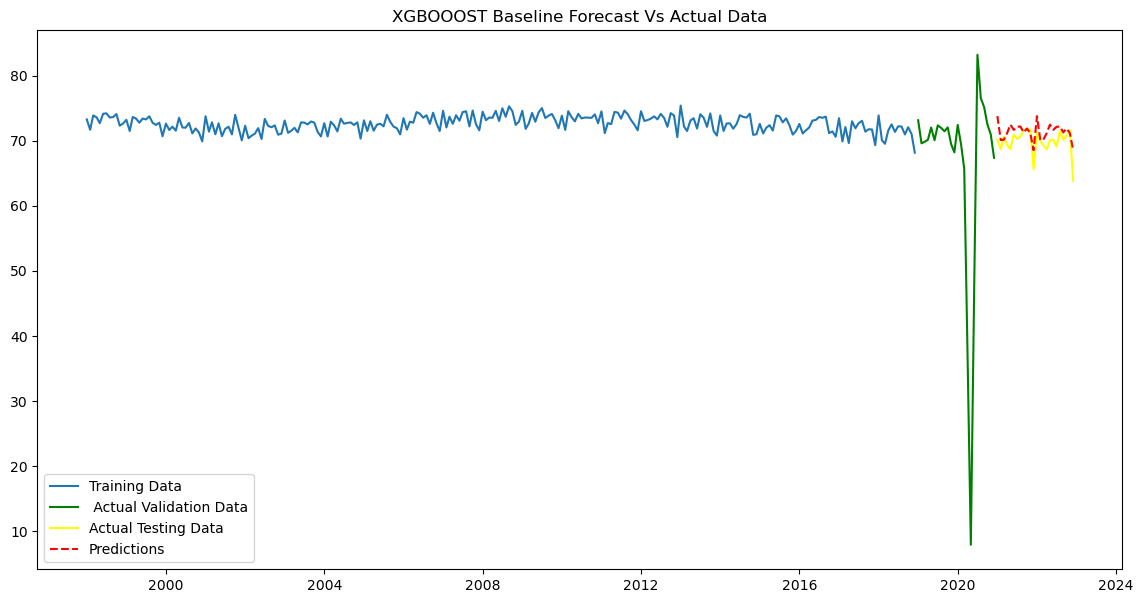

In [48]:
#visiualizing the predictions
plt.figure(figsize=(14,7))
plt.plot(train_featured.index , train_featured["logged_births"] , label = "Training Data")
plt.plot(validation_featured.index , validation_featured["logged_births"] , label = " Actual Validation Data" , color = "green")
plt.plot(test_featured.index , test_featured["logged_births"] , label = "Actual Testing Data" , color = "yellow")
plt.plot( test_featured.index , xgboost_test_pred, label = "Predictions" , color = "red" , linestyle="--")

plt.title("XGBOOOST Baseline Forecast Vs Actual Data")

plt.legend()
plt.show()

#### 7.4 Storing the Result

In [49]:
xgboost_results = {
    "MAE": xgboost_MAE_test,
    "RMSE" : xgboost_RMSE_test,
    "SMAPE" :xgboost_SMAPE_test
}


# 8 : Comparison between the Two Base Models


In [50]:
base_results_df = pd.DataFrame({
    "ARIMA Results" : arima_results,
    "XGBOOST Results": xgboost_results
})


In [51]:
base_results_df.T

,MAE,RMSE,SMAPE
ARIMA Results,2.049861,2.458499,2.916179
XGBOOST Results,1.668012,2.070258,2.380042


#  NOTE: Saving the three preprocessed and well formatted data into csv files to do the modelling on them in Google Collab


In [79]:
train_featured.to_csv("train_featured.csv")
test_featured.to_csv("test_featured.csv")
validation_featured.to_csv("validation_featured.csv")

**Note: From above comparison , it's being evident that the XGBOOST permormed well.**